In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets accelerate scikit-learn optuna sentencepiece

In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch
import optuna
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import platform
import transformers
import joblib

In [ ]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/DS학술제-모델링경진대회_Train.csv')
test = pd.read_csv('/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/DS학술제-모델링경진대회_Valid.csv')

In [ ]:
train.head(5)

,No.,발명의 명칭,요약,출원인,출원인(원문),문헌종류 코드,출원번호,출원일,등록번호,메인IPC2,...,출원인 국적,공개번호,공개일,공고번호,전체 IPC,피인용문헌 수,국가별 피특허인용 수,법적상태,현재권리자,발명자
0,1,"딥러닝 학습 모델을 이용한 당뇨병 발병 위험도 예측 시스템, 방법 및 프로그램(di...","본 발명은 빅데이터 기반의 당뇨병 발병 위험도 예측 시스템에 관한 것으로, 하나 이...",가톨릭대학교 산학협력단 | 고려대학교 산학협력단 | 숭실대학교산학협력단 | 한양대학...,-,A,2023-0155448,2023.11.10,-,G16H,...,"KR, KR, KR, KR",2023-0166054,2023.12.06,-,"G16H-050/50,[A61B-005/00, A61B-005/145, G16H-0...",0,-,거절,-,권혁상 | 고은실 | 홍옥기 | 김미경 | 김은숙 | 남가은 | 한경도 | 이민경
1,2,"질환 발병 위험도 예측 시스템, 예측 방법, 및 프로그램(system for pro...","본 발명은 빅데이터 기반의 질환 발병 위험도 예측 시스템에 관한 것으로, 하나 이상...",가톨릭대학교 산학협력단 | 고려대학교 산학협력단 | 숭실대학교산학협력단 | 한양대학...,-,A,2023-0149426,2023.11.01,2680761,G16H,...,"KR, KR, KR, KR",2023-0167748,2023.12.11,-,"G16H-050/20,[A61B-005/00, A61B-005/021, A61B-0...",0,-,등록,-,권혁상 | 고은실 | 홍옥기 | 김미경 | 김은숙 | 남가은 | 한경도 | 이민경
2,3,대사증후군 에이아이 주치의 시스템(metabolic syndrome ai prima...,"본 발명은 대사증후군 에이아이 주치의 시스템에 관한 것으로, 의료기관서버, 이용기관...",주식회사 디케이아이테크놀로지,-,A,2023-0142680,2023.10.24,2668110,G16H,...,KR,2023-0153324,2023.11.06,-,"G16H-050/20,[A61B-005/00, A61B-005/021, A61B-0...",0,-,등록,-,허경수 | 김현연
3,4,빅데이터를 이용한 스마트 병상 운영 시스템 및 방법(smart bed allocat...,실시예들은 대기환자의 입원지시 조건을 포함한 병상 배정 쿼리를 수신하는 단계; 상기...,서울대학교병원,-,A,2023-0076276,2023.06.14,2719172,G16H,...,KR,2023-0095887,2023.06.29,-,"G16H-040/20,[G06Q-010/06, G16H-010/60, G16H-05...",0,-,등록,-,정성재 | 김중섭 | 이성호 | 김동길 | 윤창호
4,5,생애 전주기 체력단련 서비스 플랫폼(service platform for life ...,본 발명은 생애 전주기에 걸친 건강 관리와 체력단련을 위한 서비스 플랫폼에 관한 것...,김재훈,-,A,2023-0064133,2023.05.18,-,G16H,...,KR,2023-0079309,2023.06.07,-,"G16H-020/30,[A63B-024/00, G16H-010/60, G16H-04...",0,-,공개,-,김재훈


In [ ]:
train = train[['발명의 명칭','요약','메인IPC2']]

In [ ]:
train['메인IPC2'].value_counts()

,count
메인IPC2,
G06Q,1791
G06F,398
G16H,215


In [ ]:
def clean_korean_documents(documents):

    for i, document in tqdm(enumerate(documents), total=len(documents), desc="Cleaning Special Characters"):
        document = re.sub(r'[^ㄱ-ㅣ가-힣\s]', '', document)
        documents[i] = document

    return documents

In [ ]:
train['요약'] = clean_korean_documents(train['요약'])
train['발명의 명칭'] = clean_korean_documents(train['발명의 명칭'])
train

Cleaning Special Characters: 100%|██████████| 2404/2404 [00:01<00:00, 2108.59it/s]


,발명의 명칭,요약,메인IPC2
0,딥러닝 학습 모델을 이용한 당뇨병 발병 위험도 예측 시스템 방법 및 프로그램 ...,본 발명은 빅데이터 기반의 당뇨병 발병 위험도 예측 시스템에 관한 것으로 하나 이상...,G16H
1,질환 발병 위험도 예측 시스템 예측 방법 및 프로그램,본 발명은 빅데이터 기반의 질환 발병 위험도 예측 시스템에 관한 것으로 하나 이상의...,G16H
2,대사증후군 에이아이 주치의 시스템,본 발명은 대사증후군 에이아이 주치의 시스템에 관한 것으로 의료기관서버 이용기관서버...,G16H
3,빅데이터를 이용한 스마트 병상 운영 시스템 및 방법,실시예들은 대기환자의 입원지시 조건을 포함한 병상 배정 쿼리를 수신하는 단계 상기 ...,G16H
4,생애 전주기 체력단련 서비스 플랫폼,본 발명은 생애 전주기에 걸친 건강 관리와 체력단련을 위한 서비스 플랫폼에 관한 것...,G16H
...,...,...,...
2399,이미지기반 빅데이터 추출 및 활용 방법 및 그를 위한 서버,본 발명은 이미지에 기반하여 빅데이터 추출 및 활용할 수 있는 이미지기반 빅데이터 ...,G06F
2400,이어폰 형태의 소리 수집 장치를 이용한 빅 데이터 기반 실시간 소음지도 제공 시스템...,본 발명은 이어폰 형태의 소리 수집 장치를 이용한 빅데이터 기반 실시간 소음지도 제...,G06F
2401,이어폰 형태의 소리 수집 장치를 이용한 빅 데이터 기반 실시간 소음지도 제공 시스템...,본 발명은 이어폰 형태의 소리 수집 장치를 이용한 빅데이터 기반 실시간 소음지도 제...,G06F
2402,익셉션 로그 빅데이터 분석에 의한 스마트 디바이스의 애플리케이션 모니터링 방법 ...,본 발명은 스마트폰 태블릿 피시 등에 설치 및 구동되는 애플리케이션의 익셉션 데이터...,G06F


In [ ]:
train = train.drop_duplicates(['발명의 명칭','요약'])
train

,발명의 명칭,요약,메인IPC2
0,딥러닝 학습 모델을 이용한 당뇨병 발병 위험도 예측 시스템 방법 및 프로그램 ...,본 발명은 빅데이터 기반의 당뇨병 발병 위험도 예측 시스템에 관한 것으로 하나 이상...,G16H
1,질환 발병 위험도 예측 시스템 예측 방법 및 프로그램,본 발명은 빅데이터 기반의 질환 발병 위험도 예측 시스템에 관한 것으로 하나 이상의...,G16H
2,대사증후군 에이아이 주치의 시스템,본 발명은 대사증후군 에이아이 주치의 시스템에 관한 것으로 의료기관서버 이용기관서버...,G16H
3,빅데이터를 이용한 스마트 병상 운영 시스템 및 방법,실시예들은 대기환자의 입원지시 조건을 포함한 병상 배정 쿼리를 수신하는 단계 상기 ...,G16H
4,생애 전주기 체력단련 서비스 플랫폼,본 발명은 생애 전주기에 걸친 건강 관리와 체력단련을 위한 서비스 플랫폼에 관한 것...,G16H
...,...,...,...
2398,이동식 무선보안 화상의료장치를 이용한 원격 진료 시스템,본 발명은 이동식 무선보안 화상의료장치를 이용한 원격 진료 시스템에 관한 것으로 실...,G06F
2399,이미지기반 빅데이터 추출 및 활용 방법 및 그를 위한 서버,본 발명은 이미지에 기반하여 빅데이터 추출 및 활용할 수 있는 이미지기반 빅데이터 ...,G06F
2400,이어폰 형태의 소리 수집 장치를 이용한 빅 데이터 기반 실시간 소음지도 제공 시스템...,본 발명은 이어폰 형태의 소리 수집 장치를 이용한 빅데이터 기반 실시간 소음지도 제...,G06F
2402,익셉션 로그 빅데이터 분석에 의한 스마트 디바이스의 애플리케이션 모니터링 방법 ...,본 발명은 스마트폰 태블릿 피시 등에 설치 및 구동되는 애플리케이션의 익셉션 데이터...,G06F


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


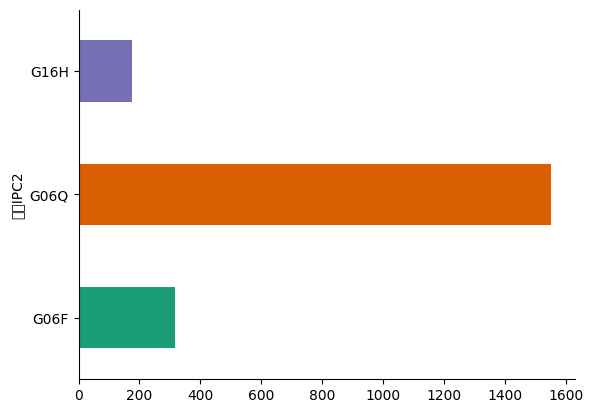

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('메인IPC2').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train['메인IPC2'].value_counts()

,count
메인IPC2,
G06Q,1550
G06F,318
G16H,175


In [ ]:
train['text'] = train['발명의 명칭'] + ' ' + train['요약']
train.head(5)

<ipython-input-14-c0bd77e11130>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['발명의 명칭'] + ' ' + train['요약']


,발명의 명칭,요약,메인IPC2,text
0,딥러닝 학습 모델을 이용한 당뇨병 발병 위험도 예측 시스템 방법 및 프로그램 ...,본 발명은 빅데이터 기반의 당뇨병 발병 위험도 예측 시스템에 관한 것으로 하나 이상...,G16H,딥러닝 학습 모델을 이용한 당뇨병 발병 위험도 예측 시스템 방법 및 프로그램 ...
1,질환 발병 위험도 예측 시스템 예측 방법 및 프로그램,본 발명은 빅데이터 기반의 질환 발병 위험도 예측 시스템에 관한 것으로 하나 이상의...,G16H,질환 발병 위험도 예측 시스템 예측 방법 및 프로그램 본 발명은...
2,대사증후군 에이아이 주치의 시스템,본 발명은 대사증후군 에이아이 주치의 시스템에 관한 것으로 의료기관서버 이용기관서버...,G16H,대사증후군 에이아이 주치의 시스템 본 발명은 대사증후군 에이아이 주치의 시...
3,빅데이터를 이용한 스마트 병상 운영 시스템 및 방법,실시예들은 대기환자의 입원지시 조건을 포함한 병상 배정 쿼리를 수신하는 단계 상기 ...,G16H,빅데이터를 이용한 스마트 병상 운영 시스템 및 방법 실시예들은 대...
4,생애 전주기 체력단련 서비스 플랫폼,본 발명은 생애 전주기에 걸친 건강 관리와 체력단련을 위한 서비스 플랫폼에 관한 것...,G16H,생애 전주기 체력단련 서비스 플랫폼 본 발명은 생애 전주기에 걸친 건강...


In [ ]:
train.to_csv("/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/train.csv", encoding='UTF-8-sig', index=False)

In [ ]:
test.head(5)

,No.,발명의 명칭,요약,출원인,출원인(원문),문헌종류 코드,출원번호,출원일,등록번호,메인IPC2,...,출원인 국적,공개번호,공개일,공고번호,전체 IPC,피인용문헌 수,국가별 피특허인용 수,법적상태,현재권리자,발명자
0,1,환자투병 관련기록을 자동으로 인식하여 분석하는 정신심리 분석 시스템(artifici...,본 발명은 메인서버는 저장장치에 저장시킨 빅데이타를 기초로 정신 및 심리분석 선정단...,하정윤,-,B1,2019-0076585,2019.06.26,2128435,G16H,...,KR,-,-,-,"G16H-050/70,[G16H-010/60, G16H-020/70, G16H-03...",2,KR(2),등록,하정윤,하정윤
1,2,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법(medicine image...,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다....,주식회사 올리브헬스케어 | 가천대학교 산학협력단,-,B1,2019-0073750,2019.06.20,2284669,G16H,...,"KR, KR",10-2020-0145931,2020.12.31,-,"G16H-010/20,[G16H-010/60]",1,KR(1),등록,주식회사 올리브헬스케어 | 가천대학교 산학협력단,이병일 | 이영호 | 최진규 | 지인서 | 박진혁 | 권현진 | 박원준
2,3,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법(medicine image...,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다....,주식회사 올리브헬스케어 | 가천대학교 산학협력단,-,A,2019-0073750,2019.06.20,2284669,G16H,...,"KR, KR",2020-0145931,2020.12.31,-,"G16H-010/20,[G16H-010/60]",1,KR(1),등록,주식회사 올리브헬스케어 | 가천대학교 산학협력단,이병일 | 이영호 | 최진규 | 지인서 | 박진혁 | 권현진 | 박원준
3,4,빅데이터 및 ａｉ 기반 병원 교대 근무자 근무표 서비스 시스템 및 방법(system...,본 발명의 일 실시예에 따른 빅데이터 및 AI 기반 병원 교대 근무자 근무표 서비스...,이창용,-,B1,2019-0065244,2019.06.03,2256850,G16H,...,KR,10-2020-0138910,2020.12.11,-,"G16H-040/20,[G06N-003/00]",2,"KR(1), CN(1)",등록,이창용,이창용
4,5,하이브리드 인지재활 시스템(hybrid cognitive rehabilitation...,"본 발명은 하이브리드 인지재활 시스템, 그리고 이를 위한 인지재활 서버에 관한 것이...",유병림,-,B1,2019-0065157,2019.06.03,2018480,G16H,...,KR,-,-,-,"G16H-020/30,[G06Q-050/22, G16H-020/70, G16H-04...",7,KR(7),소멸,유병림,유병림


In [ ]:
test = test[['발명의 명칭','요약','메인IPC2']]

In [ ]:
test['메인IPC2'].value_counts()

,count
메인IPC2,
G06Q,448
G06F,99
G16H,55


In [ ]:
test['요약'] = clean_korean_documents(test['요약'])
test['발명의 명칭'] = clean_korean_documents(test['발명의 명칭'])
test

Cleaning Special Characters: 100%|██████████| 602/602 [00:00<00:00, 3192.39it/s]


,발명의 명칭,요약,메인IPC2
0,환자투병 관련기록을 자동으로 인식하여 분석하는 정신심리 분석 시스템,본 발명은 메인서버는 저장장치에 저장시킨 빅데이타를 기초로 정신 및 심리분석 선정단...,G16H
1,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다 ...,G16H
2,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다 ...,G16H
3,빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시스템 및 방법 ...,본 발명의 일 실시예에 따른 빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시...,G16H
4,하이브리드 인지재활 시스템,본 발명은 하이브리드 인지재활 시스템 그리고 이를 위한 인지재활 서버에 관한 것이다...,G16H
...,...,...,...
597,홍채 정보 추출 방법 및 장치,본 개시는 홍채근의 움직임을 추출하는 방법 및 장치에 관련\n한다 개시된 방법은 ...,G06F
598,화면 요구사항 수집 및 절차 관리 방법,본 발명은 소프트웨어의 화면 설계에 대한 고객 요구사항을 기반으로 주요 기능을 정의...,G06F
599,환경 빅데이터 및 머신 러닝을 기반으로 한 고분자 재료의 사용 수명 예측 방법 ...,본 발명은 환경 빅데이터 및 머신 러닝 알고리즘을 기반으로 고분자 재료의 사용 수명...,G06F
600,환경 빅데이터 및 머신 러닝을 기반으로 한 고분자 재료의 사용 수명 예측 방법 ...,본 발명은 환경 빅데이터 및 머신 러닝 알고리즘을 기반으로 고분자 재료의 사용 수명...,G06F


In [ ]:
test = test.drop_duplicates(['발명의 명칭','요약'])
test

,발명의 명칭,요약,메인IPC2
0,환자투병 관련기록을 자동으로 인식하여 분석하는 정신심리 분석 시스템,본 발명은 메인서버는 저장장치에 저장시킨 빅데이타를 기초로 정신 및 심리분석 선정단...,G16H
1,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다 ...,G16H
3,빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시스템 및 방법 ...,본 발명의 일 실시예에 따른 빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시...,G16H
4,하이브리드 인지재활 시스템,본 발명은 하이브리드 인지재활 시스템 그리고 이를 위한 인지재활 서버에 관한 것이다...,G16H
5,기반의 멀티 헬스케어 서비스 스마트홈 플랫폼 시스템 및 그 구동 방법 ...,본 발명은 멀티 헬스케어 서비스 스마트홈 플랫폼 시스템 및 그 구동 방법에 관한 것...,G16H
...,...,...,...
596,혼잡도 제공 시스템 및 방법,본 발명은 혼잡도 제공 시스템 및 방법에 관한 것이다 개시된 혼잡도 제공 시스템 및...,G06F
597,홍채 정보 추출 방법 및 장치,본 개시는 홍채근의 움직임을 추출하는 방법 및 장치에 관련\n한다 개시된 방법은 ...,G06F
598,화면 요구사항 수집 및 절차 관리 방법,본 발명은 소프트웨어의 화면 설계에 대한 고객 요구사항을 기반으로 주요 기능을 정의...,G06F
599,환경 빅데이터 및 머신 러닝을 기반으로 한 고분자 재료의 사용 수명 예측 방법 ...,본 발명은 환경 빅데이터 및 머신 러닝 알고리즘을 기반으로 고분자 재료의 사용 수명...,G06F


In [ ]:
test['text'] = test['발명의 명칭'] + ' ' + test['요약']
test.head(5)

<ipython-input-23-c6fdfbd5dff2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text'] = test['발명의 명칭'] + ' ' + test['요약']


,발명의 명칭,요약,메인IPC2,text
0,환자투병 관련기록을 자동으로 인식하여 분석하는 정신심리 분석 시스템,본 발명은 메인서버는 저장장치에 저장시킨 빅데이타를 기초로 정신 및 심리분석 선정단...,G16H,환자투병 관련기록을 자동으로 인식하여 분석하는 정신심리 분석 시스템 ...
1,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법,본 발명은 임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법에 관한 것이다 ...,G16H,임상시험참여자를 위한 의약품 이미지 분석 시스템 및 방법 본 발명...
3,빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시스템 및 방법 ...,본 발명의 일 실시예에 따른 빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시...,G16H,빅데이터 및 기반 병원 교대 근무자 근무표 서비스 시스템 및 방법 ...
4,하이브리드 인지재활 시스템,본 발명은 하이브리드 인지재활 시스템 그리고 이를 위한 인지재활 서버에 관한 것이다...,G16H,하이브리드 인지재활 시스템 본 발명은 하이브리드 인지재활 시스템 ...
5,기반의 멀티 헬스케어 서비스 스마트홈 플랫폼 시스템 및 그 구동 방법 ...,본 발명은 멀티 헬스케어 서비스 스마트홈 플랫폼 시스템 및 그 구동 방법에 관한 것...,G16H,기반의 멀티 헬스케어 서비스 스마트홈 플랫폼 시스템 및 그 구동 방법 ...


In [ ]:
test.to_csv("/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/test.csv", encoding='UTF-8-sig', index=False)

## **데이터모델링** 체크포인트

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/test.csv')

In [ ]:
## 원하는 데이터 수
target_size = 1550

# 각 레이블별로 데이터 수 조정
balanced_data = []


for label, group in train.groupby('메인IPC2'):
    group_size = len(group)

    if group_size < target_size:
        # 오버샘플링: 부족한 만큼 데이터를 복제
        # 필요한 수만큼 복제하여 추가
        n_to_sample = target_size - group_size
        sampled_group = group.sample(n=n_to_sample, replace=True, random_state=42)
        balanced_data.append(pd.concat([group, sampled_group]))
    else:
        sampled_group = group.sample(n=target_size, random_state=42)
        balanced_data.append(sampled_group)

# 최종 데이터 프레임 생성
balanced_train = pd.concat(balanced_data).reset_index(drop=True)

# 최종 데이터 확인
print(balanced_train['메인IPC2'].value_counts())
train=balanced_train

메인IPC2
G06F    1550
G06Q    1550
G16H    1550
Name: count, dtype: int64


In [ ]:
X_train = train['text']
y_train = train['메인IPC2']
X_test = test['text']
Y_test = test['메인IPC2']

In [ ]:
#모델 적용을 위한 라벨 인코더
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_labels = len(label_encoder.classes_)

In [ ]:
#kobert 모델과 토크나이저 생성
model_name = 'monologg/kobert'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
#텍스트 토큰화 함수 정의
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

In [ ]:
print(len(X_train))  # X_train의 길이 (행의 개수)
print(len(y_train_encoded))  # y_train_encoded의 길이

4650
4650


In [ ]:
# 데이터셋 생성 및 토크나이즈
train_df = pd.DataFrame({'text': X_train, 'label': y_train_encoded})
test_df = pd.DataFrame({'text': X_test})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4650 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [ ]:
# PyTorch 텐서 형식으로 변환
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
import torch

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)  # 계산된 accuracy
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': accuracy, 'f1': f1}  # accuracy를 return 값에 추가

In [ ]:

training_args = TrainingArguments(
    output_dir='/content/results',
    num_train_epochs=18,  # 에포크 수 고정
    per_device_train_batch_size=64,  # 배치 크기 고정
    learning_rate=5e-5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy="epoch",
    logging_dir='/content/logs',
    logging_steps=10,
    fp16=True,
    disable_tqdm=False,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    report_to="none"
)

# 최적의 파라미터로 Trainer 구성
model = AutoModelForSequenceClassification.from_pretrained('monologg/kobert', num_labels=3)

trainer4 = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # 전체 학습 데이터로 평가
    compute_metrics=compute_metrics
)

# 학습을 시작합니다.
trainer4.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.570500,0.344821,0.899785,0.898858
2,0.248700,0.134524,0.968602,0.968517
3,0.147700,0.110278,0.974839,0.974731
4,0.114300,0.105798,0.976559,0.976564
5,0.085700,0.060429,0.984946,0.984914
6,0.060000,0.039496,0.990968,0.990953
7,0.039300,0.035007,0.993118,0.993113
8,0.025800,0.011085,0.997204,0.997203
9,0.016900,0.006399,0.998065,0.998064
10,0.010500,0.006136,0.998925,0.998925


TrainOutput(global_step=1314, training_loss=0.0749424280686647, metrics={'train_runtime': 1493.8819, 'train_samples_per_second': 56.029, 'train_steps_per_second': 0.88, 'total_flos': 1.10112965319168e+16, 'train_loss': 0.0749424280686647, 'epoch': 18.0})

In [ ]:
import joblib

joblib.dump(trainer4, '/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/trainer4.pkl')

print("모델이 저장되었습니다.")

모델이 저장되었습니다.


In [ ]:
# 8. 저장된 모델로 테스트 데이터 예측 및 결과 저장
# 저장된 모델 불러오기

loaded_model = joblib.load('/content/drive/MyDrive/4-2/2024_데이터분석_모델링_경진대회/trainer4.pkl')

# 불러온 모델을 사용하여 예측 수행
predictions4 = loaded_model.predict(test_dataset)

test_predictions4 = np.argmax(predictions4.predictions, axis=1)
decoded_test_predictions4 = label_encoder.inverse_transform(test_predictions4)

In [ ]:
test["메인IPC2"] = decoded_test_predictions4

selected_columns4 = test[['메인IPC2']]
selected_columns4.head(10)

,메인IPC2
0,G16H
1,G16H
2,G06Q
3,G06Q
4,G06Q
5,G16H
6,G06Q
7,G06Q
8,G16H
9,G16H


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


predicted_labels = decoded_test_predictions4
true_labels = Y_test.values

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Model accuracy: {accuracy}")

Model accuracy: 0.872093023255814
